# Prep

## Dependencies

In [1]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-25 19:07:11.918866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

## Constants

In [2]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 100
VALID_SPLIT = 0.2
LABEL_COLUMN = 'label'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
RANDOM_STATE = 41

## Prepare Dataset

In [3]:
# Get paths
raw_data_path = path.join(os.getcwd(), "data")

In [4]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
df = get_image_df(raw_data_path)
df.sample(5).head()

,image_path,label
113,covid/1.CXRCTThoraximagesofCOVID-19fromSingapo...,covid
371,normal/00001992_000.png,normal
253,normal/00003137_001.png,normal
5,covid/covid-19-pneumonia-evolution-over-a-week...,covid
99,covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg,covid


In [5]:
# Stratify split into train and test
train_df, test_df = train_test_split(df,
                                     test_size=VALID_SPLIT,
                                     shuffle=True,
                                     stratify=df[LABEL_COLUMN],
                                     random_state=RANDOM_STATE
                                    )

## Load dataset

In [6]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                       rescale=1./255,
                       horizontal_flip = True,
                       rotation_range=10,

                       # featurewise_center = True, # Not Center image, center values, across all images
                       # featurewise_std_normalization = True, # Normalise across all images
                       # width_shift_range=0.2,
                       # height_shift_range=0.2,
                       shear_range=0.25,
                       zoom_range=0.1,
                       # zca_whitening = True,
                       # channel_shift_range = 20,

                       # vertical_flip = True,
                       # validation_split = 0.2,
                       fill_mode='constant')

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

flow_kwargs = {
    'directory': raw_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}
train_batches = train_datagen.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
valid_batches = test_datagen.flow_from_dataframe(dataframe=test_df, shuffle=False, **flow_kwargs)

# In this case test batches are valid batches, there was no test set for this paper
test_batches = valid_batches

DATASETS = {
    'train': train_batches,
    'test': test_batches,
}

Found 500 validated image filenames belonging to 2 classes.
Found 125 validated image filenames belonging to 2 classes.


Compute class weights

In [7]:
y_train = train_batches.classes
class_weights = dict(
    zip(
        np.unique(y_train),
        class_weight.compute_class_weight('balanced', classes=np.unique(y_train), 
        y=y_train)
    )
) 
class_weights

{0: 0.625, 1: 2.5}

# EDA

In [8]:
train_batches.class_indices, len(train_df), len(test_df)

({'normal': 0, 'covid': 1}, 500, 125)

In [9]:
print("Number of examples in training:", len(train_df))
print("Number of examples in validation:", len(test_df))

Number of examples in training: 500
Number of examples in validation: 125


In [10]:
xb, yb = train_batches.next()
xb.shape,yb.shape

((32, 256, 256, 3), (32, 2))

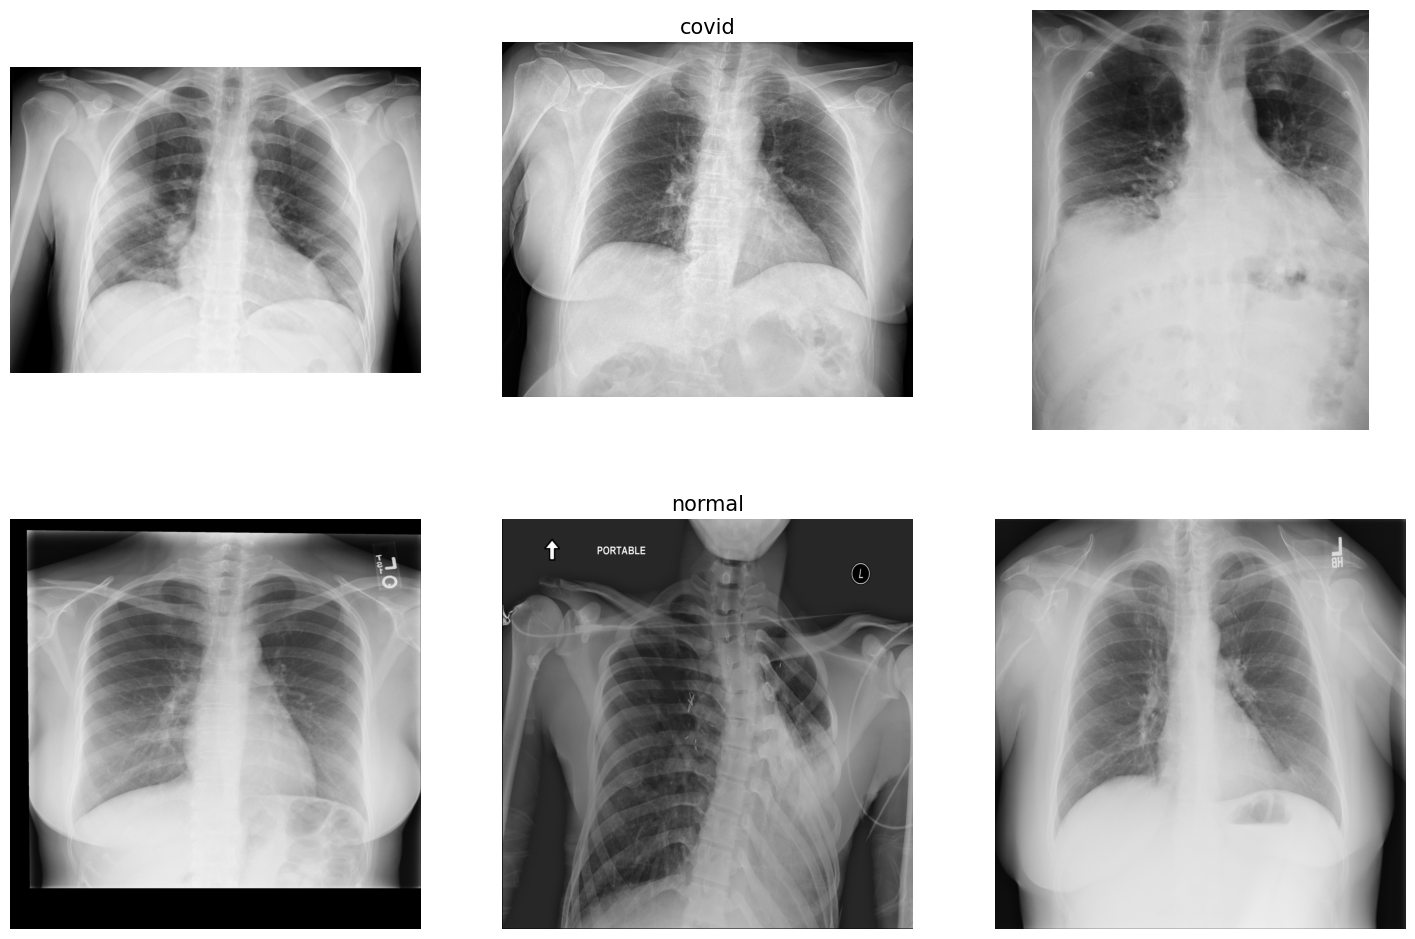

In [11]:
def display_class_sample(df, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(raw_data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

display_class_sample(train_df)

# Train Model

## Build DarkCovidNet (modified Darknet model)

In [12]:
def conv_block(num_filters, kernel_size=3, stride=1, padding="same", **kwargs):
    strides = (stride, stride) # Assuming symmetric stride
    return [
        layers.Conv2D(filters=num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                     use_bias=False, **kwargs),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1)] # Matching torchvision

In [13]:
def triple_conv(num_filters_outer, num_filters_inner, name="triple"):
    return [
        *conv_block(num_filters_outer, name=f"{name}_start"),
        *conv_block(num_filters_inner, kernel_size=1, padding="same"),
        *conv_block(num_filters_outer, name=f"{name}_end")]

In [17]:
def maxpooling():
    return layers.MaxPool2D((2,2))

In [14]:
def build_model(summary=True):
    model = keras.Sequential([
        layers.Input(shape=(256, 256, 3)),

        # Conv block 1
        *conv_block(8),
        maxpooling(),

        # Conv block 2
        *conv_block(16),
        maxpooling(),

        # Triple conv 1
        *triple_conv(32, 16, name="triple_1"),
        maxpooling(),

        # Triple conv 2
        *triple_conv(64, 32, name="triple_2"),
        maxpooling(),

        # Triple conv 3
        *triple_conv(128, 64, name="triple_3"),
        maxpooling(),

        # Triple conv 4
        *triple_conv(256, 128, name="triple_4"),

        # Conv block 3
        *conv_block(128, kernel_size=1),

        # Conv block 4
        *conv_block(256),

        # Conv layer 1
        layers.Conv2D(filters=2, kernel_size=3, strides=(1,1), padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),

        # Dense
        layers.Flatten(),
        layers.Dense(2, activation=None)
        ]
    )

    model.build()

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
           metrics = ['accuracy'], steps_per_execution=1)
    if summary:
        print(model.summary())
        
    return model

In [18]:
model = build_model(summary=False)

2023-04-25 17:36:49.337881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-25 17:36:49.337953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive): /proc/driver/nvidia/version does not exist
2023-04-25 17:36:49.338794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit Model

In [19]:
OUT_MODEL_PATH = "./models"

def train_model_and_save_results(*args, out_path=OUT_MODEL_PATH, save_final=True, **kwargs):
    out_path = path.join(out_path, datetime.now().isoformat())
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+"{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    callbacks=kwargs.get("callbacks", [])

    history = model.fit(callbacks=[*callbacks, save_model], *args, **kwargs)
    np.save(path.join(out_path, "history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + "last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

In [37]:
LOAD_MODEL = True

best_checkpoint = path.join(OUT_MODEL_PATH, "./best", "0042-0.99.tf")
    
if LOAD_MODEL:
    model_path = path.join(OUT_MODEL_PATH, "./best")
    checkpoint_path = path.join(model_path, "0042-0.99.tf")
    history_path = path.join(model_path, "history.npy")
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
else:
    history = train_model_and_save_results(train_batches,
                                 validation_data=test_batches,
                                 epochs=NUM_EPOCHS,
                                 workers=1,)
                                 # class_weight=class_weights)

# Evaluate

In [22]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    
    batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    
    for idx in tqdm(range(len(batches))):
        img_batch, y_batch = batches[idx]
        
        preds_batch = model.predict(img_batch, verbose=0)
        
        if single_binary_neuron:
            # For single neuron with binary class probabily output
            y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
        else:
            # For multi class or binary class using 2 neurons
            y_pred_batch = np.argmax(preds_batch, axis=-1)
            
        y_true_batch = np.argmax(y_batch,-1)
        
        
        y_pred_batches.append(y_pred_batch)
        y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)
    
    return y_pred, y_true

def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True):
    y_pred, y_true = get_pred_and_truth(model, dataset)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'val'], loc='upper left')
    plt.show()

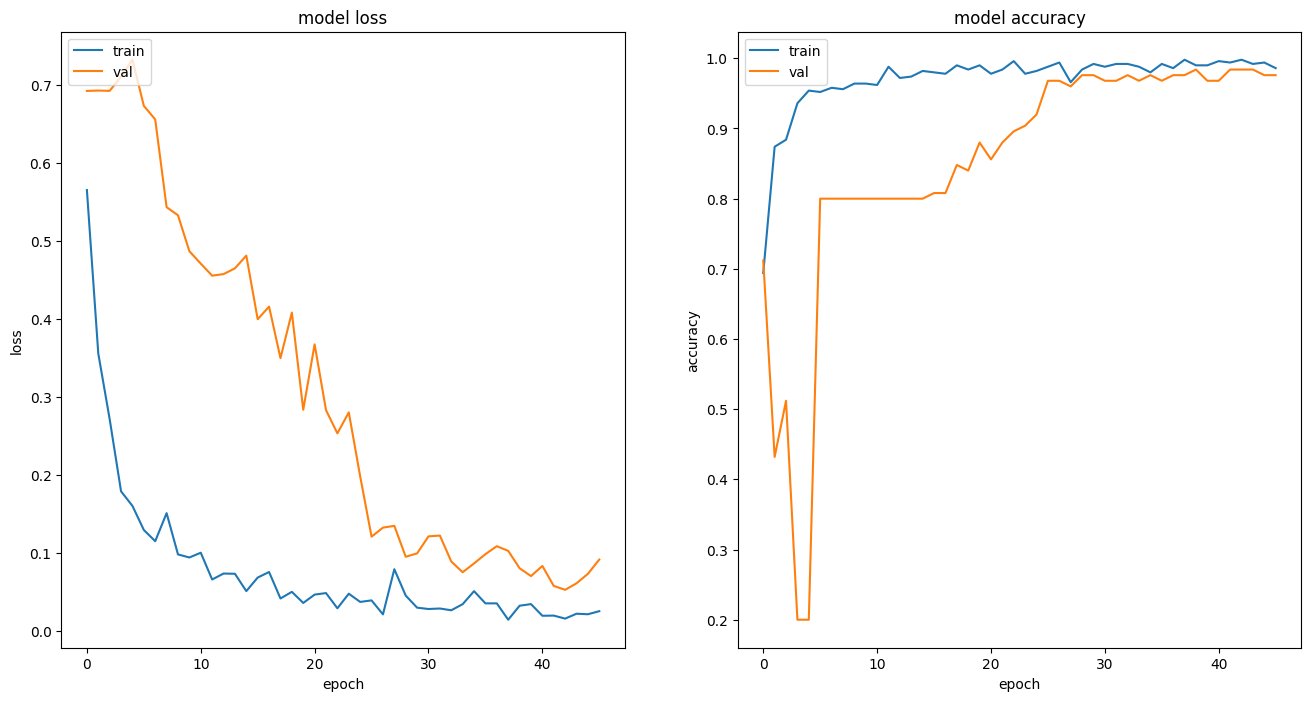

In [38]:
plot_loss_accuracy_curves(history, plot=True, limit_epochs=46)

  0%|          | 0/16 [00:00<?, ?it/s]


----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,0.994000
1,Recall,1.000000
2,Specificity,0.992500
3,Precision,0.970874
4,F1 Score,0.985222


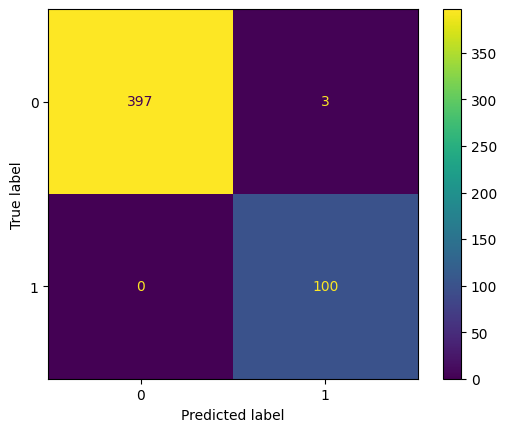

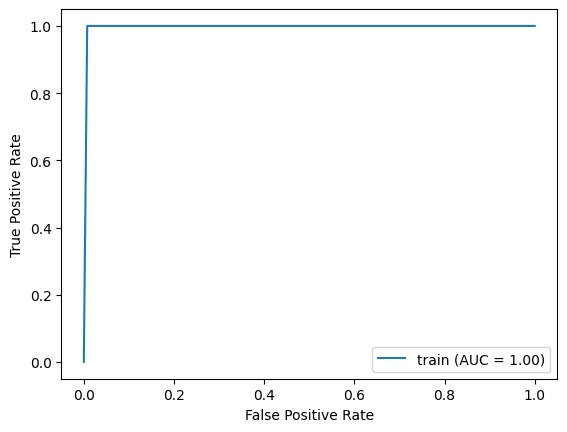

  0%|          | 0/4 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.984000
1,Recall,0.920000
2,Specificity,1.000000
3,Precision,1.000000
4,F1 Score,0.958333


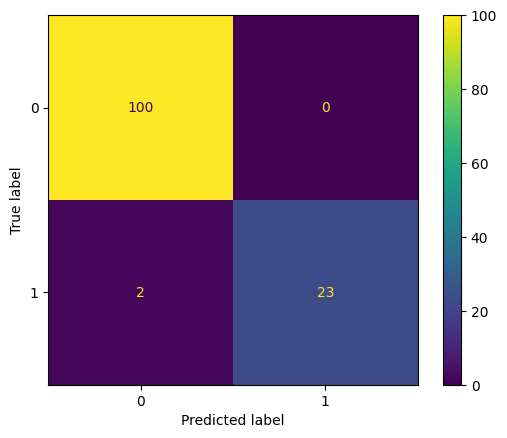

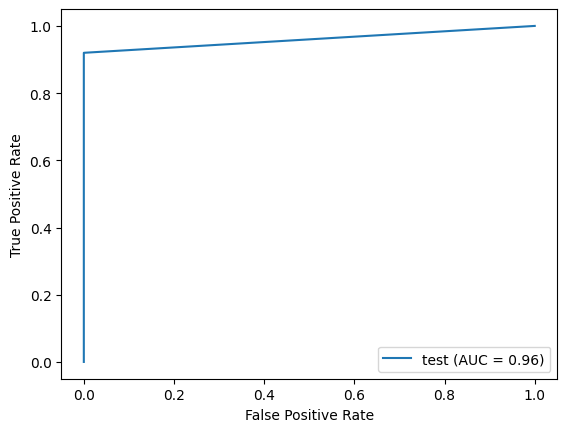

In [41]:
evaluate_on_all_datasets(model)